In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib



Bad key "text.kerning_factor" on line 4 in
/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import networkx as nx

In [3]:
import tensorflow as tf
sess = tf.compat.v1.InteractiveSession()

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from scipy import spatial
from scipy.spatial import cKDTree
import scipy.sparse as sp

In [6]:
from numpy import linalg as LA
from numpy.linalg import inv
from sklearn.decomposition import PCA
import pandas as pd

import cmath

In [7]:
import time
class tictoc():
    def __init__(self):
        self.prev = 0
        self.now = 0
    def tic(self):
        self.prev = time.time()
    def toc(self):
        self.now = time.time()
        print( "dt(s) = %.3g" %(self.now - self.prev))
        t = self.now - self.prev
        self.prev = time.time()
        return t
        
tt = tictoc()

In [8]:
#Circular network
i = 500
Adj = eye(i,i,1)+eye(i,i,-1) 
Adj[0][-1] = 1
Adj[-1][0] = 1



In [9]:
len(Adj)

500

In [10]:
n =200
for j in range(2, n+1):
    Adj += diag(ones(i-j), j) + diag(ones(i-j), -j) + diag(ones(j), i-j) + diag(ones(j), -(i-j))

In [11]:
density = []
for k in range(8):
    i = 50
    Adj = eye(i,i,1)+eye(i,i,-1) 
    Adj[0][-1] = 1
    Adj[-1][0] = 1
    
    for j in range(2, k+1):
        Adj += diag(ones(i-j), j) + diag(ones(i-j), -j) + diag(ones(j), i-j) + diag(ones(j), -(i-j))
    
    
    G = nx.from_numpy_matrix(Adj)
    
    density += [ 2*len(G.edges())/(i*(i-1))  ]

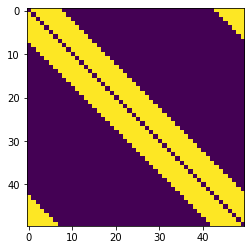

In [14]:
imshow(Adj)

In [15]:
# add neighbors
G = nx.from_numpy_matrix(Adj+matmul(Adj,Adj)+ matmul(Adj,matmul(Adj,Adj)) + matmul(Adj, matmul(Adj,matmul(Adj,Adj))))

In [16]:
# Full connected network
##i = 1000
##Adj = ones((i,i)) - eye(i,i)

In [17]:
#generate a graph from the adjacency matrix
G = nx.from_numpy_matrix(Adj)

In [18]:
G = nx.grid_2d_graph(25, 25, periodic = True)


#relable the graph and use one integers as an id
label = ([ i[0] for i in list(G.nodes(data=True))])

mapping = dict([ [label[i], i] for i in range(len(label))])
G = nx.relabel_nodes(G, mapping)


In [19]:
#G= nx.barabasi_albert_graph(500, 1)

for i in range(1000):
    G = nx.erdos_renyi_graph(500, 0.01)
    if nx.is_connected(G) == True:
        print('True')
        break
nx.info(G), nx.is_connected(G)

True


('Name: \nType: Graph\nNumber of nodes: 500\nNumber of edges: 1267\nAverage degree:   5.0680',
 True)

In [20]:
#<k> = p(N-1)

5/(500-1)

0.01002004008016032

In [26]:
pos = nx.circular_layout(G)#kamada_kawai_layout(G)

In [27]:
#import json

#for k, v in pos.items():
#    a = list(v)
#    pos[k]= a

#with open('./Result12_K/Position.json', 'w') as f:
#    json.dump(pos, f)

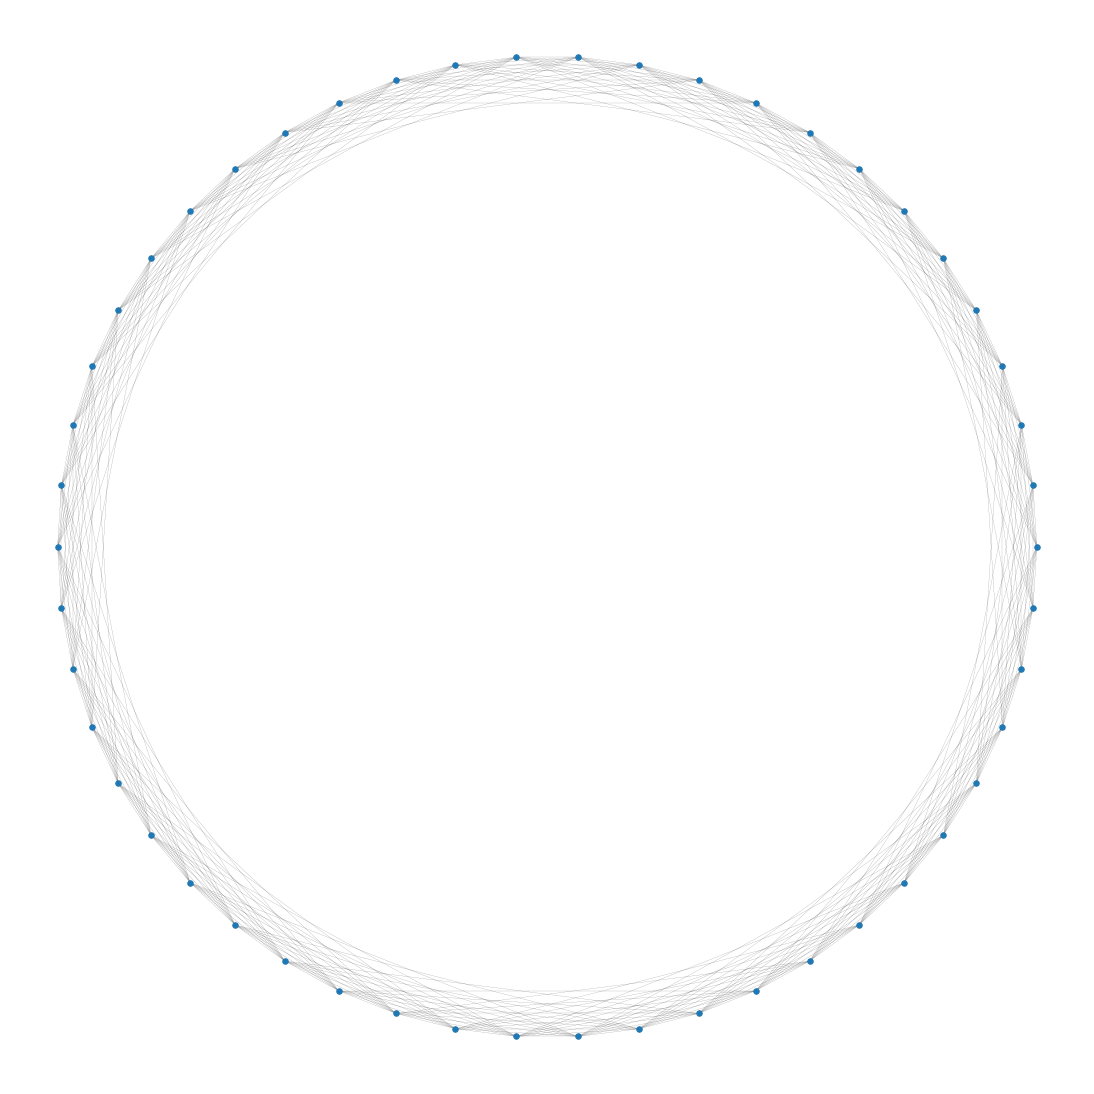

In [31]:
plt.figure(figsize = (15,15))

nx.draw(G, pos, node_size = 30, width = .1)


In [29]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [11]:
G =nx.complete_graph(3)

In [21]:
#adjacency mtx


A = nx.to_numpy_matrix(G)
#A = matrix(A)


N = len(A)

print(N)

500


In [22]:
len(A)

500

In [23]:
#first neighbors
#adjacency_list = torch.where(torch.triu(torch.tensor(A)))
adjacency_list = torch.where((torch.tensor(A)))
len(adjacency_list[0])

2534

In [24]:
#second neighbors
sa = []

for i in G.nodes(data= True):
    for j in G.neighbors(i[0]):
        for k in G.neighbors(j):
            if i[0] != j and k != j: #i[0] !=k
                sa += [[i[0], j, k]]
                
sa = array(sa)

len(sa)

15418

In [25]:
#first neighbor impact to other first neighbor
fa = []

for i in G.nodes(data= True):
    for j in G.neighbors(i[0]):
        for k in G.neighbors(i[0]):
            if j != i[0] and k!= i[0]: #j != k:
                fa += [[i[0], j, k]]
                
fa = array(fa)

len(fa)

15418

In [26]:
fadj = ( torch.tensor(fa[:,0]), torch.tensor(fa[:,1]), torch.tensor(fa[:,2]))

In [27]:
sadj = ( torch.tensor(sa[:,0]), torch.tensor(sa[:,1]), torch.tensor(sa[:,2]))

In [30]:
#sparse
A = sp.coo_matrix(A)

A_norm = A + sp.eye(N)
D_norm = sp.diags((1/np.sqrt(A_norm.sum(0))).tolist()[0])
D_norm = D_norm.tocsr()
DAD = D_norm.dot(A_norm.dot(D_norm))
DAD = DAD.tocoo()

DAD = sparse_mx_to_torch_sparse_tensor(DAD)

In [31]:
#A_norm = torch.tensor(A)+torch.eye(N) #normalized adjacency mtx
#degree_norm = torch.diag(1/torch.sqrt(torch.sum(A_norm, 0))) #torch.tensor(deg) 
#DAD = torch.matmul(torch.matmul(degree_norm, A_norm),degree_norm) # D**(-1/2) A D**(-1/2)

#imshow(DAD);
#colorbar();

In [32]:
#outputs dimension - they are the phases

#dim = 1 
#x = torch.eye(N)

#print(x.size())

In [33]:
#input, output dimensions
dim = 1
#x = torch.eye(N) #.to(device)
x = sp.eye(N)
x = x.tocoo()
x = sparse_mx_to_torch_sparse_tensor(x)

In [34]:
class GCN(nn.Module):
    def __init__(self, input_dim, output_dim, adj_mx):
        super(GCN, self).__init__()
        self.input_dim = input_dim
        self.adj_mx = adj_mx
        self.output_dim = output_dim
        #self.dense = nn.Linear(input_dim, output_dim,bias=False)
        self.weight = torch.nn.Parameter(torch.nn.init.uniform_(torch.FloatTensor(self.input_dim, self.output_dim), a=0.0, b=2*pi )) 
    #def reset_parameters(self):
    #    stdv = 1. / math.sqrt(self.weight.size(1))
    #    self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, input):
        support = torch.spmm(input, self.weight)
        output = torch.spmm(self.adj_mx, support)
        
        return output

In [35]:
class NeuralSync_Sparse(nn.Module):
    def __init__(self, num_nodes, output_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3,adj_mtx):
        super(NeuralSync_Sparse, self).__init__()
        self.num_nodes = num_nodes
        self.output_dim = output_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.hidden_dim_3 = hidden_dim_3
        self.adj_mtx = adj_mtx
        
        self.weight1 = torch.nn.Parameter(torch.nn.init.uniform_(torch.FloatTensor(self.num_nodes, self.hidden_dim_1), a=0.0, b=2*pi ))
        
        self.GCN1 = GCN(self.hidden_dim_1, self.output_dim,self.adj_mtx.float())
        
        self.LR = nn.LeakyReLU()
        self.Sigmoid = nn.Sigmoid()
        
 
    def forward(self, inp):
        x = torch.spmm(inp, self.weight1)
        
        gnn1 = self.GCN1(x)
        
        gnn1 %= (2*pi)
  
        output = self.LR(gnn1)
    
        #output = self.Sigmoid(gnn1)*(2*pi)
    
        return  output

In [36]:
class LinearSync_Sparse(nn.Module):
    def __init__(self, num_nodes, output_dim):
        super(LinearSync_Sparse, self).__init__()
        self.num_nodes = num_nodes
        self.output_dim = output_dim
        
        #self.weight1 = torch.nn.Parameter(torch.nn.init.uniform_(torch.FloatTensor(self.num_nodes, self.output_dim), a=0.0, b=2*pi ))
        self.weight1 = torch.nn.Parameter(torch.nn.init.uniform_(torch.FloatTensor(self.num_nodes, self.output_dim), a=0.0, b=2*pi ))
        
        
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
 
    def forward(self, inp):
        x = torch.spmm(inp, self.weight1)
        
        output = x#self.Tanh(x)*(2*pi) #self.Sigmoid(x)*(2*pi)
    
        return  output

In [37]:
#initialize phases between 0 and 2pi
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight, a=0.0, b=2*pi)

In [38]:
#Kuramoto-model

omega = .1

def custom_loss_K(output, l =1):
    
    X = output
    
    X1 = X[adjacency_list[0]] #torch.index_select(input =X, dim = 0, index = adjacency_list[0], out=None)
    X2 = X[adjacency_list[1]] #torch.index_select(input =X, dim = 0, index = adjacency_list[1], out=None)
        
    V = (-1/2)*torch.sum( torch.cos(X1-X2), axis = 0)
    #V = torch.sum(omega*output) -l*torch.sum(torch.cos(X2-X1), axis = 0)
    
    return V

In [39]:
#Hopf-Kuramoto model



def custom_loss_KH(output, C, S1, S2):
    
    X = output
    
    XX1 = X[adjacency_list[0]]
    XX2 = X[adjacency_list[1]]
    
    X1 = X[sadj[0]] #torch.index_select(input =X, dim = 0, index = adjacency_list[0], out=None)
    X2 = X[sadj[1]] #torch.index_select(input =X, dim = 0, index = adjacency_list[1], out=None)
    X3 = X[sadj[2]] #torch.index_select(input =X, dim = 0, index = adjacency_list[1], out=None)
        
    XXX1 = X[fadj[0]] #torch.index_select(input =X, dim = 0, index = adjacency_list[0], out=None)
    XXX2 = X[fadj[1]] #torch.index_select(input =X, dim = 0, index = adjacency_list[1], out=None)
    XXX3 = X[fadj[2]]    
        
    V = -( C*torch.sum( torch.cos(XX2-XX1), axis = 0)  + S1*torch.sum( torch.sin(XX2-XX1), axis = 0) + S2*( torch.sum( torch.sin(2*X2-X3-X1) - torch.sin(X3-X1)  , axis = 0) + torch.sum(torch.sin(XXX3+XXX2-2*XXX1), axis = 0) ))
    #V = -(-C*torch.sum( torch.sin(XX2-XX1), axis = 0)  + S1*torch.sum( torch.cos(XX2-XX1), axis = 0) + S2*(torch.sum( torch.cos(2*X2-X3-X1) - torch.cos(X3-X1)  , axis = 0) + (1/2)*torch.sum(torch.cos(XXX3+XXX2-2*XXX1), axis = 0) ))
    
    
    return V

In [40]:
#stopping
def difference(r):
    return abs((max(r)-min(r))/max(r))

In [41]:
#S1_sample = np.logspace(-2,1,15) #linspace(0.5,10,20)
#S2_sample = np.logspace(-2,1,15) #linspace(0.01,10,20)

for i in range(100):
    s_name = str(i)                
    
    Lin(1 , s_name, 0.01)
        
    Neural(1, s_name, 0.01)



NameError: name 'Lin' is not defined

6.251974842553391e-08
dt(s) = 1.6


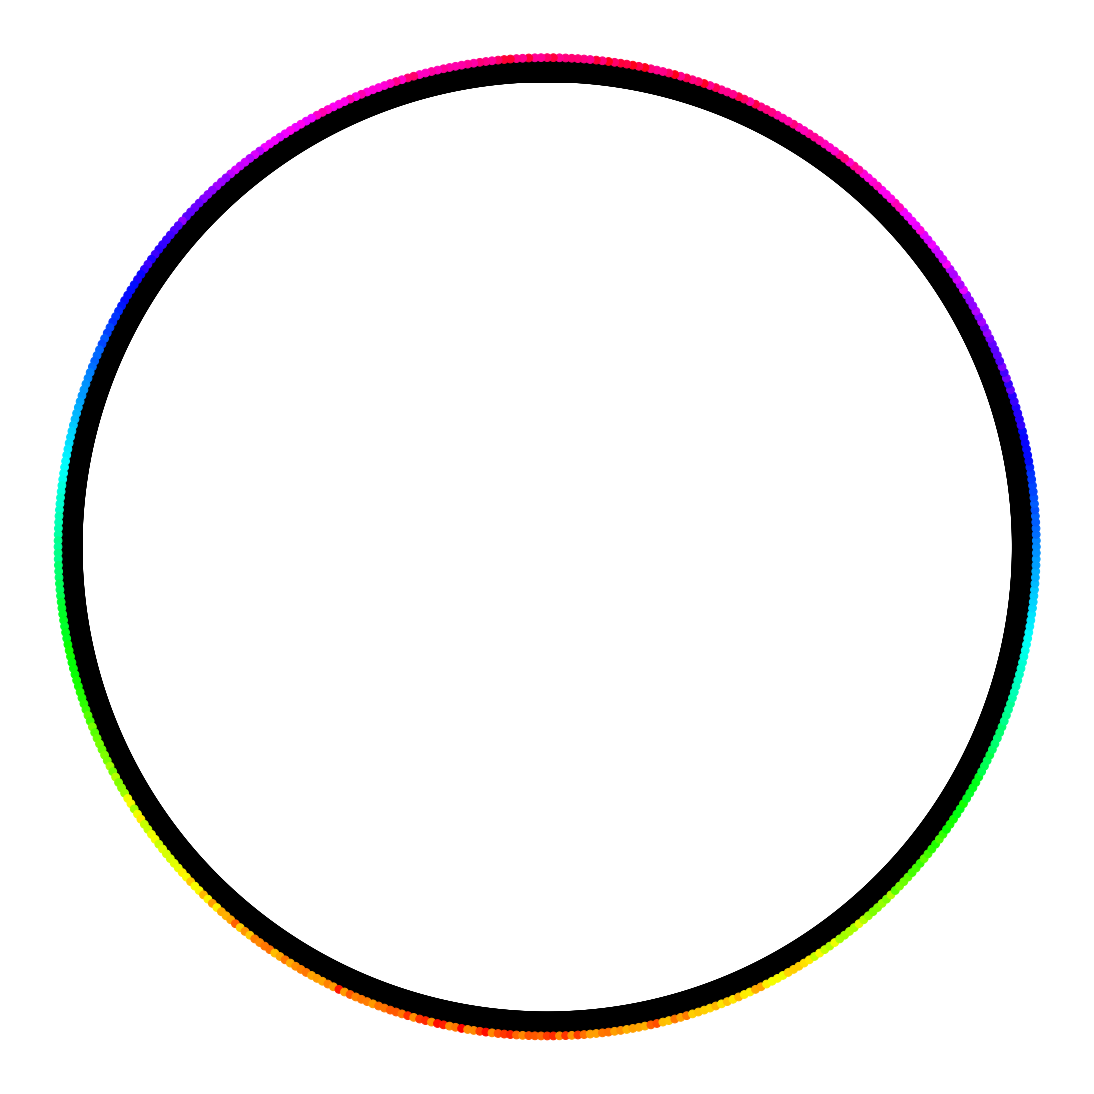

In [156]:
Lin(10, '1', lr = 0.01)
#Lin(1, 5, .1, '5_0.1_sparse-positive-lin', lr = .001)
#Lin(1, 1, .1, '1_0.1_sparse-positive-lin', lr = .01)
#Lin(1, .6, .3, '0.6_0.3_sparse-positive-lin', lr = .01)
#Lin(1, 5, 12, '5_12_sparse-positive-lin', lr = .01)

/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Finished training neural:  0
dt(s) = 523


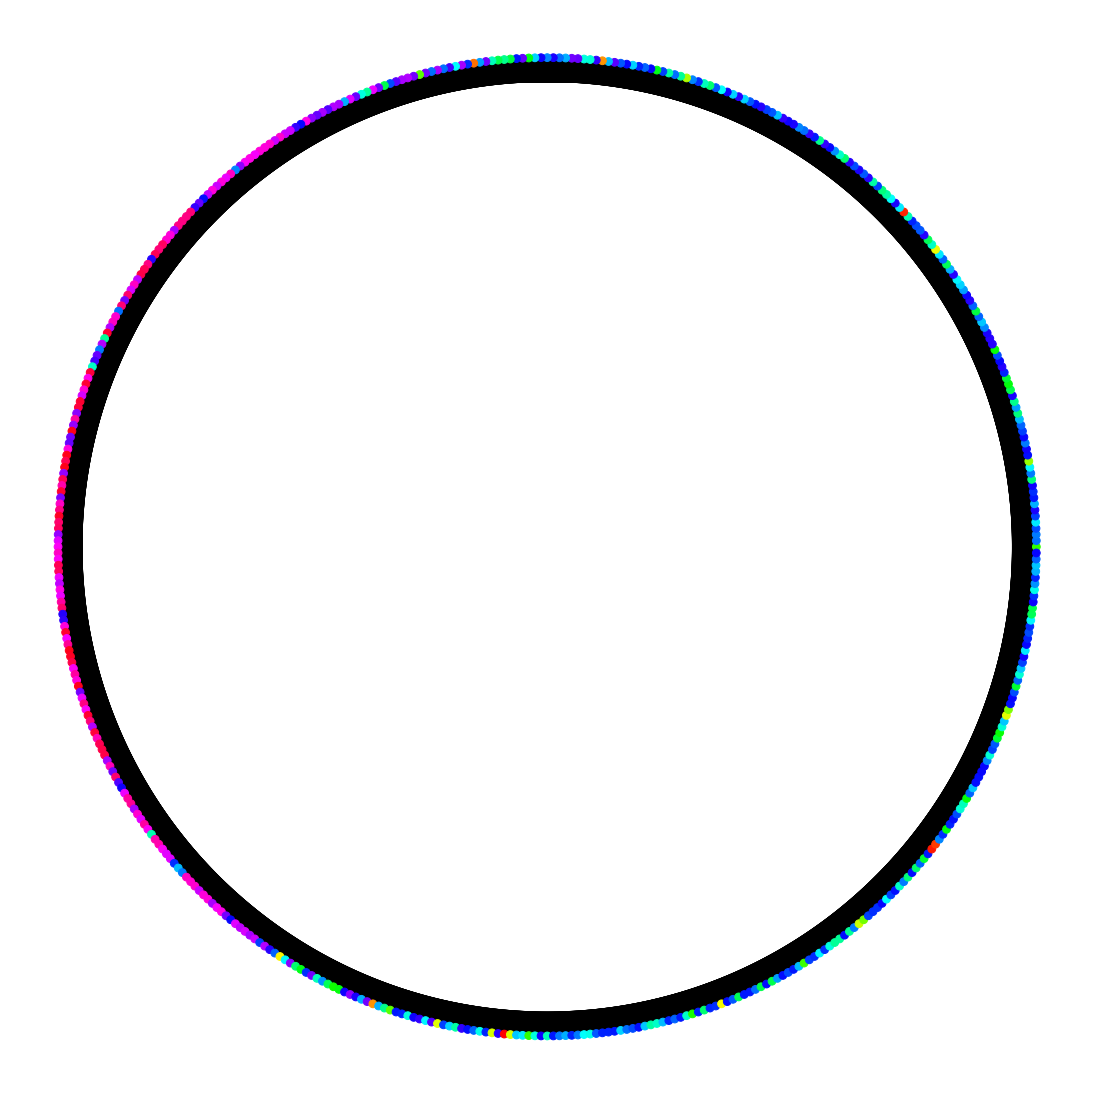

In [143]:
Neural(1, '1', lr = 0.01)
#Neural(1, 5, .1, '5_0.1_sparse-positive-pi', lr=.01)
#Neural(1, 1, .1, '1_0.1_sparse-positive-pi', lr=.01)
#Neural(1, .6, .3, '0.6_0.3_sparse-positive-pi', lr=.01)
#Neural(1, 5, 12, '5_12_sparse-positive-pi', lr=.01)

In [151]:
d =array([ double(i[0].split('(')[1].split(',')[0]) for i in pd.read_csv('./Result17_K/500circle-linear-1-pattern.csv').values])

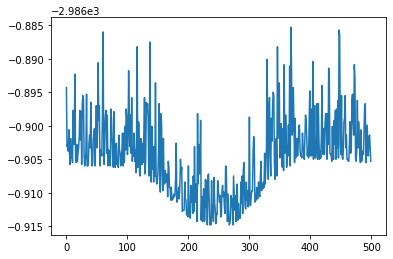

In [148]:
plot(d)

In [42]:
lr = .001
time_hist = []
state_history_lin = []

patience = 10
r = list(np.zeros(patience))

o_ev = []

for i in range(1):
        #x = torch.eye(N)
    
    net = nn.Linear(N, dim, bias=False)
    #net = LinearSync_Sparse(N,dim)
    net.apply(init_weights)

    #optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    criterion = custom_loss_K
    loss_history_lin= [] 

    tt.tic()
    for epoch in range(200000):  
        inp = x
        

        optimizer.zero_grad()

        outputs = net(inp)
        
        o_ev += [ [ l[0] for l in outputs.detach().numpy()]]
        
        state_history_lin += [outputs]
        
            
        loss = criterion(outputs)#, l)#C,  S1, S2)

    
        loss.backward(retain_graph=True)
        optimizer.step()
        
        loss_history_lin.append(loss.item())
        
        
        r.append(loss.item())
        r.pop(0)
        
       
        if (difference(r)) < 10e-8:
            print(difference(r))
            break
                
    
        
    time_hist += [tt.toc()]

/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


9.63465485149673e-08
dt(s) = 3.37


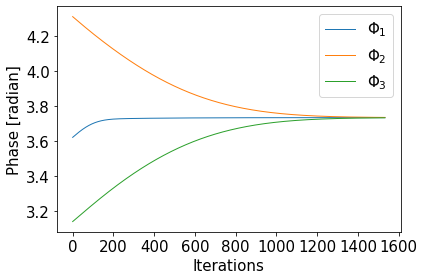

In [95]:
plot(o_ev[:,0], label = '$\Phi_1$', linewidth = 1,alpha = 1)
plot(o_ev[:,1], label = '$\Phi_2$', linewidth = 1,alpha = 1)
plot(o_ev[:,2], label = '$\Phi_3$', linewidth = 1,alpha = 1)



plt.legend(loc=1, prop={"size":15});



xlabel('Iterations',size=15)
ylabel('Phase [radian]' ,size=15)
plt.xticks(size=15)
plt.yticks(size=15);

plt.tight_layout();

#xlim(.01);

#plt.savefig('./paper_optimizer/3_phases.pdf');


In [50]:
o_ev[0,:]

array([2.640806 , 3.183683 , 1.0433017], dtype=float32)

In [29]:
def Lin(s_name, lr):
    time_hist = []
    state_history_lin = []

    patience = 10
    r = list(np.zeros(patience))


    for i in range(1):
        #x = torch.eye(N)
    
        #net = nn.Linear(N, dim, bias=False)
        net = LinearSync_Sparse(N,dim)
        net.apply(init_weights)

        optimizer = torch.optim.SGD(net.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
        criterion = custom_loss_K#H
        loss_history_lin= [] 
    
        tt.tic()
        for epoch in range(200000):  
            inp = x
        
    
            optimizer.zero_grad()

            outputs = net(inp)
        
            state_history_lin += [outputs]
        
            
            loss = criterion(outputs)#, l)#C,  S1, S2)

    
            loss.backward(retain_graph=True)
            optimizer.step()
        
            loss_history_lin.append(loss.item())
        
        
            r.append(loss.item())
            r.pop(0)
        
       
            if (difference(r)) < 10e-8:
                print(difference(r))
                break
                
    
        
        time_hist += [tt.toc()]
        
        d = pd.DataFrame(time_hist)
        d.to_csv('./paper_optimizer2/25x25-linear-%s-time.csv' %(s_name), header=True,index=False)

        d = pd.DataFrame(loss_history_lin)
        d.to_csv('./paper_optimizer2/25x25-linear-%s-loss.csv' %(s_name), header=True,index=False)
        
        d = pd.DataFrame(state_history_lin[-1])
        d.to_csv('./paper_optimizer2/25x25-linear-%s-pattern.csv' %(s_name), header=True,index=False)
        
        
        ##c = array([ round(double(i), 5)%(2*pi) for i in state_history_lin[-1].detach()])
        #plt.figure(figsize = (10,10))
        #a = nx.draw_kamada_kawai(G, node_color=c, cmap=plt.cm.hsv_r)
        
        ##plt.figure(figsize = (15,15))

        ##nx.draw(G, pos, node_size = 60, node_color=c, cmap=plt.cm.hsv_r)
        #plt.colorbar(list(c));
        
        
        ##plt.savefig('./paper_optimizer2/25x25-linear-%s.svg' %(s_name), dpi=300, bbox_inches='tight')
        ##plt.show();

In [120]:
Lin('1-sgd-.1', lr = .1)

/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


0.0
dt(s) = 0.26


In [104]:
def Neural(s_name,lr):
    time_hist = []
    state_history = []


    patience = 10
    r = list(np.zeros(patience))

    for i in range(1):
        #x = torch.eye(N)
    
        net = NeuralSync_Sparse(num_nodes=N, output_dim=dim, hidden_dim_1=10, hidden_dim_2=10, hidden_dim_3=5, adj_mtx= torch.tensor(DAD))
        #net = NeuralSync(num_nodes=N, output_dim=dim, hidden_dim_1=10, hidden_dim_2=10, hidden_dim_3=5, adj_mtx= torch.tensor(DAD))
    
    
        net.apply(init_weights)


        optimizer = torch.optim.SGD(net.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
        criterion = custom_loss_K#H
        loss_history_gcn= [] 
    
        tt.tic()
        for epoch in range(100):  
            inp = x
        
    
            optimizer.zero_grad()

            outputs = net(inp)
        
            state_history += [outputs]
        
            #print(outputs)

            loss = criterion(outputs)#, l) #C, S1, S2)

    
            loss.backward(retain_graph=True)
            optimizer.step()
        
            loss_history_gcn.append(loss.item())
        
            r.append(loss.item())
            r.pop(0)
            
            
            #if (difference(r)) < 10e-10:
            #    print(difference(r))
            #    break
    
        net1 = nn.Linear(N, dim, bias=False)
        net1.weight = torch.nn.Parameter(outputs.t().detach())
        #optimizer1 = torch.optim.Adam(net1.parameters(), lr=lr)
        optimizer1 = torch.optim.SGD(net1.parameters(), lr=lr)
    
    
        for epoch1 in range(300000):
            inp = x
    
            optimizer1.zero_grad()
            outputs1 = net1(inp)
        
            state_history += [outputs1]
        
            loss1 = criterion(outputs1)#, l) #C, S1, S2)

            loss1.backward(retain_graph=True)
            optimizer1.step()
        
            loss_history_gcn.append(loss1.item())
        
            r.append(loss1.item())
            r.pop(0)
        
       
            if (difference(r)) < 10e-8:
                print(difference(r))
                break
    
        
        print('Finished training neural: ', i)
    

        time_hist += [tt.toc()]
        
        d = pd.DataFrame(time_hist)
        d.to_csv('./paper_optimizer2/25x25-neuralsync-%s-time.csv' %(s_name), header=True,index=False)

        d = pd.DataFrame(loss_history_gcn)
        d.to_csv('./paper_optimizer2/25x25-neuralsync-%s-loss.csv' %(s_name), header=True,index=False)
        
        d = pd.DataFrame(state_history[-1])
        d.to_csv('./paper_optimizer2/25x25-neuralsync-%s-pattern.csv' %(s_name), header=True,index=False)
        
        
        ##c = array([ round(double(i), 5)%(2*pi) for i in state_history[-1].detach()])
        #plt.figure(figsize = (10,10))
        #a = nx.draw_kamada_kawai(G, node_color=c, cmap=plt.cm.hsv_r)
        
        ##plt.figure(figsize = (15,15))

        ##nx.draw(G, pos, node_size = 60, node_color=c, cmap=plt.cm.hsv_r)
        
        #plt.colorbar(list(c));
        
        
        ##plt.savefig('./Result17_K/500circle-neuralsync-%s.svg' %(s_name), dpi=300, bbox_inches='tight')
        ##plt.show();

In [114]:
Neural('3-sgd-.001', lr = .001)

/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


9.768141441125165e-08
Finished training neural:  0
dt(s) = 37


In [30]:
c1 = [228/255,26/255,28/255]

c2 = [55/255,126/255,184/255]

c3 = [77/255,175/255,74/255]

c4 = [152/255,78/255,163/255]

c5 = [255/255,127/255,0/255]

c6 = [255/255,255/255,51/255]

c7 = [166/255,86/255,40/255]

c = [c1, c2, c3, c4, c5, c7, c6]

In [115]:
def lowess(x, y, f=1./3.):
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and
             only normally distributed errors. 
        - No higher order polynomials d=1 
            so linear smoother.
    """
    # get some paras
    xwidth = f*(x.max()-x.min()) # effective width after reduction factor
    N = len(x) # number of obs
    # Don't assume the data is sorted
    order = np.argsort(x)
    # storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # define the weigthing function -- clipping too!
    tricube = lambda d : np.clip((1- np.abs(d)**3)**3, 0, 1)
    # run the regression for each observation i
    for i in range(N):
        dist = np.abs((x[order][i]-x[order]))/xwidth
        w = tricube(dist)
        # form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # solve the syste
        sol = np.linalg.solve(ATA, ATb)
        # predict for the observation only
        yest = A[i].dot(sol)# equiv of A.dot(yest) just for k
        place = order[i]
        y_sm[place]=yest 
        sigma2 = (np.sum((A.dot(sol) -y [order])**2)/N )
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    return y_sm, y_stderr

In [146]:
def msp(x, y, z):
    
    x = [i for i in x]
    y = [i for i in y]
    z = [i for i in z]
    
    lenx = len(x)
    leny = len(y)
    lenz = len(z)
    
    
    
    len_mean = int(mean([lenx, leny, lenz]))
   
    if lenx < len_mean:
        x += list(ones(len_mean - lenx)*x[-1] )
    else:
        x = x[:len_mean]
    
    if leny < len_mean:
        y += list(ones(len_mean - leny)*y[-1] )
    else:
        y = y[:len_mean]
    
    if lenz < len_mean:
        z += list(ones(len_mean - lenz)*z[-1] )
    else:
        z = z[:len_mean]
    
    
    mean_out = ([ mean([x[i], y[i], z[i]]) for i in range(len_mean)] )
    std_out = ([ std([x[i], y[i], z[i]]) for i in range(len_mean)] )
    
    
    
    a1 = array(range(0, len(mean_out)) ,dtype='float')

    a2 = array(mean_out, dtype='float')
    a3 = array(std_out, dtype='float')
    
    y_sm, y_std = lowess(a1, a2 , f=1./100.)
    y_er, y_er_std = lowess(a1, a3 , f=1./100.)
    
    return [a1, y_sm, y_sm - y_er , y_sm + y_er]

In [147]:
def msp1(x, y, z, tx, ty, tz):
    
    x = [i for i in x]
    y = [i for i in y]
    z = [i for i in z]
    
    tx = [i for i in tx]
    ty = [i for i in ty]
    tz = [i for i in tz]
    
    print(len(x), len(tx), len(y), len(ty), len(z), len(tz))
    
    lenx = len(x)
    leny = len(y)
    lenz = len(z)
    
    time = [tx, ty, tz]
    tid = [len(tx), len(ty), len(tz)].index(min([len(tx), len(ty), len(tz)]))
    
    t = array([float(i) for i in time[tid]])
    print(len(t))
    
    len_mean = int(mean([lenx, leny, lenz]))
    
    
   
    if lenx < len_mean:
        x += list(ones(len_mean - lenx)*x[-1] )
    else:
        x = x[:len_mean]
    
    if leny < len_mean:
        y += list(ones(len_mean - leny)*y[-1] )
    else:
        y = y[:len_mean]
    
    if lenz < len_mean:
        z += list(ones(len_mean - lenz)*z[-1] )
    else:
        z = z[:len_mean]
    
    
    mean_out = ([ mean([x[i], y[i], z[i]]) for i in range(len_mean)] )
    std_out = ([ std([x[i], y[i], z[i]]) for i in range(len_mean)] )
    
    print(len(mean_out))
    
    a1 = array(range(0, len(mean_out)) ,dtype='float')

    a2 = array(mean_out, dtype='float')[:len(t)]
    a3 = array(std_out, dtype='float')[:len(t)]
    
    y_sm, y_std = lowess(t, a2 , f=1./1.)
    y_er, y_er_std = lowess(t, a3 , f=1./1.)
    
    return [t, y_sm, y_sm - y_er , y_sm + y_er]

In [55]:
#1
d_lin_1_adam = pd.read_csv('./paper_optimizer2/25x25-linear-1-Adam-.001-loss.csv').values
d_lin_2_adam = pd.read_csv('./paper_optimizer2/25x25-linear-2-Adam-.001-loss.csv').values
d_lin_3_adam = pd.read_csv('./paper_optimizer2/25x25-linear-3-Adam-.001-loss.csv').values

t_lin_1_adam = pd.read_csv('./paper_optimizer2/25x25-linear-1-Adam-.001-time.csv').values
t_lin_2_adam = pd.read_csv('./paper_optimizer2/25x25-linear-2-Adam-.001-time.csv').values
t_lin_3_adam = pd.read_csv('./paper_optimizer2/25x25-linear-3-Adam-.001-time.csv').values

#2
d_gcn_1_adam = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-Adam-.001-loss.csv').values
d_gcn_2_adam = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-Adam-.001-loss.csv').values
d_gcn_3_adam = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-Adam-.001-loss.csv').values


t_gcn_1_adam = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-Adam-.001-time.csv').values
t_gcn_2_adam = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-Adam-.001-time.csv').values
t_gcn_3_adam = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-Adam-.001-time.csv').values

print('adam: ', mean([t_lin_1_adam/t_gcn_1_adam, t_lin_2_adam/t_gcn_2_adam, t_lin_3_adam/t_gcn_3_adam]) )  # mean([t_gcn_1_adam,t_gcn_2_adam,t_gcn_3_adam]))

#3
d_lin_1_rms = pd.read_csv('./paper_optimizer2/25x25-linear-1-rms-.001-loss.csv').values
d_lin_2_rms = pd.read_csv('./paper_optimizer2/25x25-linear-2-rms-.001-loss.csv').values
d_lin_3_rms = pd.read_csv('./paper_optimizer2/25x25-linear-3-rms-.001-loss.csv').values

t_lin_1_rms = pd.read_csv('./paper_optimizer2/25x25-linear-1-rms-.001-time.csv').values
t_lin_2_rms = pd.read_csv('./paper_optimizer2/25x25-linear-2-rms-.001-time.csv').values
t_lin_3_rms = pd.read_csv('./paper_optimizer2/25x25-linear-3-rms-.001-time.csv').values
          
#4
d_gcn_1_rms = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-rms-.001-loss.csv').values
d_gcn_2_rms = pd.read_csv('./paper_optimizer2/25x25-neuralsync-2-rms-.001-loss.csv').values
d_gcn_3_rms = pd.read_csv('./paper_optimizer2/25x25-neuralsync-3-rms-.001-loss.csv').values

t_gcn_1_rms = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-rms-.001-time.csv').values
t_gcn_2_rms = pd.read_csv('./paper_optimizer2/25x25-neuralsync-2-rms-.001-time.csv').values
t_gcn_3_rms = pd.read_csv('./paper_optimizer2/25x25-neuralsync-3-rms-.001-time.csv').values


print('rms: ', mean([t_lin_1_rms/t_gcn_1_rms, t_lin_2_rms/t_gcn_2_rms, t_lin_3_rms/t_gcn_3_rms]) ) #/ mean([t_gcn_1_rms,t_gcn_2_rms,t_gcn_3_rms]))

#5
d_lin_1_sgd = pd.read_csv('./paper_optimizer2/25x25-linear-1-sgd-.001-loss.csv').values
d_lin_2_sgd = pd.read_csv('./paper_optimizer2/25x25-linear-2-sgd-.001-loss.csv').values
d_lin_3_sgd = pd.read_csv('./paper_optimizer2/25x25-linear-3-sgd-.001-loss.csv').values

t_lin_1_sgd = pd.read_csv('./paper_optimizer2/25x25-linear-1-sgd-.001-time.csv').values
t_lin_2_sgd = pd.read_csv('./paper_optimizer2/25x25-linear-2-sgd-.001-time.csv').values
t_lin_3_sgd = pd.read_csv('./paper_optimizer2/25x25-linear-3-sgd-.001-time.csv').values

#6
d_gcn_1_sgd = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-sgd-.001-loss.csv').values
d_gcn_2_sgd = pd.read_csv('./paper_optimizer2/25x25-neuralsync-2-sgd-.001-loss.csv').values
d_gcn_3_sgd = pd.read_csv('./paper_optimizer2/25x25-neuralsync-3-sgd-.001-loss.csv').values


t_gcn_1_sgd = pd.read_csv('./paper_optimizer2/25x25-neuralsync-1-sgd-.001-time.csv').values
t_gcn_2_sgd = pd.read_csv('./paper_optimizer2/25x25-neuralsync-2-sgd-.001-time.csv').values
t_gcn_3_sgd = pd.read_csv('./paper_optimizer2/25x25-neuralsync-3-sgd-.001-time.csv').values


print('sgd: ', mean([t_lin_1_sgd/t_gcn_1_sgd, t_lin_2_sgd/t_gcn_2_sgd, t_lin_3_sgd/t_gcn_3_sgd]) ) #/ mean([t_gcn_1_sgd,t_gcn_2_sgd,t_gcn_3_sgd]))


adam:  1.1585344510003326
rms:  1.5480172156428658
sgd:  0.4467687023916271


In [56]:
# lr = 0.001

lr001 = [0.001, 0.001, 0.001]
s001 = [1.15, 1.54, 0.44]

#adam:  1.1585344510003326
#rms:  1.5480172156428658
#sgd:  0.4467687023916271

# lr = 0.01

#adam:  1.9682922650807078
#rms:  1.7021043061750774
#sgd:  1.145039185875601


lr01 = [0.01, 0.01, 0.01]
s01 = [1.96, 1.70, 1.14]
    
    
# lr = 0.1

#adam:  1.3293909191034614
#rms:  0.9751024878284135
#sgd:  0.7533839001569484

lr1 = [0.1, 0.1, 0.1]
s1 = [1.32, 0.95, 0.68]


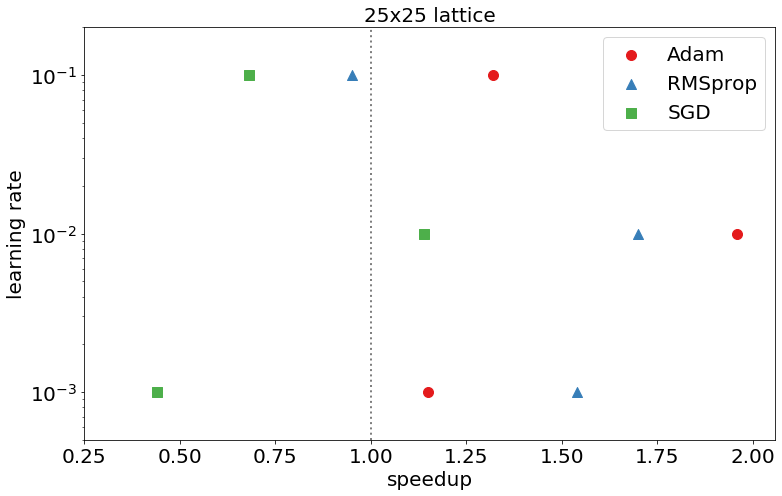

In [57]:
figure(figsize = (11, 7))
s= 100

marker = ['o', '^', 's']
color = [c1, c2, c3]
for i in range(3):    
    scatter(s1[i], lr1[i], marker = marker[i], s = s, color = color[i])
    scatter(s01[i], lr01[i], marker = marker[i], s = s, color = color[i])
    scatter(s001[i], lr001[i], marker = marker[i], s = s, color = color[i])

scatter(0, 0, color=c[0], alpha = 1, s = s, marker = marker[0], label = 'Adam')
scatter(0, 0, color=c[1], alpha = 1, s = s, marker = marker[1], label = 'RMSprop')
scatter(0, 0, color=c[2], alpha = 1, s = s, marker = marker[2], label = 'SGD')
plt.legend(loc=0, prop={"size":20} , ncol= 1);

plt.axvline(x=1, color='black', linestyle='dotted', linewidth = 2, alpha = 0.5)
    

yscale('log')

ylim(0.0005, 0.2 )
xlim(0.25, )


xlabel('speedup', fontname='sherif',size=20)
ylabel('learning rate', fontname='sherif',size=20)

plt.xticks(fontname='sherif',size=20)
plt.yticks(fontname='sherif',size=20);

title('25x25 lattice', fontname='sherif',size=20);



plt.tight_layout();


/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/numpy/core/_methods.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. Fo

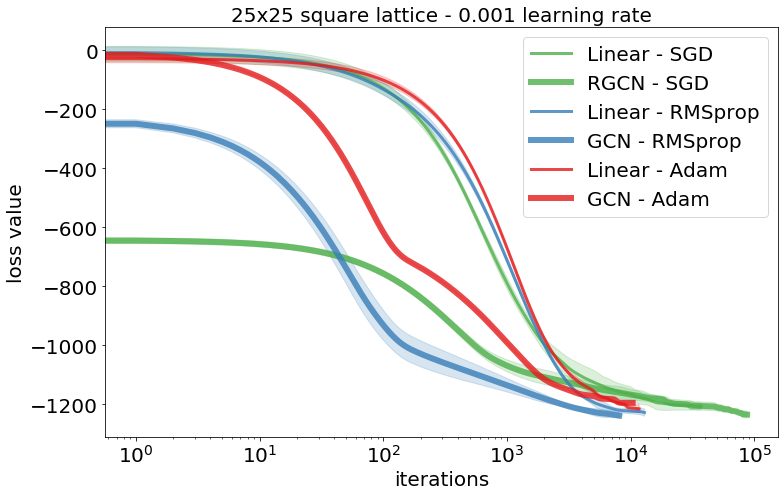

In [160]:
figure(figsize = (11, 7))
a = .8
l = 3

ab = 0.2


d5 = msp(d_lin_1_sgd, d_lin_2_sgd,d_lin_3_sgd)
plot(d5[0], d5[1], color = c3, label = 'Linear - SGD', linewidth = l,alpha = a)
plt.fill_between( d5[0], d5[2] ,d5[3], alpha=ab, color = c3)

d6 = msp(d_gcn_1_sgd, d_gcn_2_sgd,d_gcn_3_sgd)
plot(d6[0], d6[1], color = c3, label = 'RGCN - SGD', linewidth = 2*l,alpha = a)
plt.fill_between( d6[0], d6[2] ,d6[3], alpha=ab, color = c3)

d3 = msp(d_lin_1_rms, d_lin_2_rms,d_lin_3_rms)
plot(d3[0], d3[1], color = c2, label = 'Linear - RMSprop', linewidth = l,alpha = a)
plt.fill_between( d3[0], d3[2] ,d3[3], alpha=ab, color = c2)

d4 = msp(d_gcn_1_rms, d_gcn_2_rms,d_gcn_3_rms)
plot(d4[0], d4[1], color = c2, label = 'GCN - RMSprop', linewidth = 2*l,alpha = a)
plt.fill_between( d4[0], d4[2] ,d4[3], alpha=ab, color = c2)

d1 = msp(d_lin_1_adam, d_lin_2_adam,d_lin_2_adam)
plot(d1[0], d1[1], color = c1, label = 'Linear - Adam', linewidth = l,alpha = a)
plt.fill_between( d1[0], d1[2] ,d1[3], alpha=ab, color = c1)


d2 = msp(d_gcn_1_adam, d_gcn_2_adam,d_gcn_3_adam)
plot(d2[0], d2[1], color = c1, label = 'GCN - Adam', linewidth = 2*l, alpha = a)
plt.fill_between( d2[0], d2[2] ,d2[3], alpha=ab, color = c1)
#d1 = msp1(d_lin_1, d_lin_2,d_lin_3, t_lin_1, t_lin_2,t_lin_3)


#plt.axvline(x=100, color='black', linestyle='dotted', linewidth = l, alpha = a)

plt.legend(loc=1, prop={"size":20});

xscale('log')

xlabel('iterations',fontname='sherif',size=20)
ylabel('loss value', fontname='sherif',size=20)
plt.xticks(fontname='sherif',size=20)
plt.yticks(fontname='sherif',size=20);

#title('Tree graph (625 nodes)', fontname='sherif',size=20), 
title('25x25 square lattice - 0.001 learning rate', fontname='sherif',size=20), 
#title('Circle graph (625 nodes)', fontname='sherif',size=20), 

plt.tight_layout();

#xlim(.01);

plt.savefig('./paper_optimizer/25x25_lattice_0.001_lr.pdf');


#plt.savefig('./fig2/625_tree_op_it_loss_alpha0_lw.svg');

#plt.savefig('./fig2/625_tree_lattice_it_loss_alpha0_lw.svg');

In [ ]:
figure(figsize = (11, 7))
s= 100
a = .7

c = [c1, c2, c3, c4, c5]
l = ['1', '2', '3', '4', '5']

for i in range(5):
    
#scatter(Resgcn_auto_A2[0][0], Resgcn_auto_A2[1][0], color=c1, alpha = a, s = 3*s, marker = 'o', label = 'S1 = .5 , s2= .01')
    scatter(Resgcn_A2[0][i], Resgcn_A2[1][i], color=c[i], alpha = a, s = 3*s, marker = 'o')
    scatter(Resgcn_A[0][i], Resgcn_A[1][i], color=c[i], alpha = a, s = s, marker = 'o')

#scatter(gcn_auto_A2[0][0], Resgcn_50_A2[1][0], color=c1, alpha = a, s = 3*s, marker = 's')
    scatter(gcn_A2[0][i], gcn_A2[1][i], color=c[i], alpha = a, s = 3*s, marker = 's' )
    scatter(gcn_A[0][i], gcn_A[1][i], color=c[i], alpha = a, s = s, marker = 's' )
    if i == 0 :
        scatter(0, 0, color='grey', alpha = a, s = 3*s, marker = 'o', label = r'RGCN $A^2$')
        scatter(0, 0, color='grey', alpha = a, s = s, marker = 'o', label = r'RGCN $A$')

#scatter(gcn_auto_A2[0][0], Resgcn_50_A2[1][0], color=c1, alpha = a, s = 3*s, marker = 's')
        scatter(0, 0, color='grey', alpha = a, s = 3*s, marker = 's', label = r'GCN $A^2$')
        scatter(0, 0, color='grey', alpha = a, s = s, marker = 's', label = r'GCN $A$')
        plt.legend(loc=0, prop={"size":20} , ncol= 2);
    
grid(zorder=0)   
    

xscale('log')

#xlim(1, 120)

xlabel('speedup', fontname='sherif',size=20)
ylabel('loss linear - loss neural', fontname='sherif',size=20)

plt.xticks(fontname='sherif',size=20)
plt.yticks(fontname='sherif',size=20);

title('Hopf - Kuramoto model', fontname='sherif',size=20);



plt.tight_layout();

#plt.savefig('./fig6/50x50-HK-stoplin10-8.pdf');